In [314]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary

# load
X = pd.read_csv("/content/X.csv")
y = pd.read_csv("/content/Y.csv")

In [315]:
X.head(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age
0,-1.475950,-1.451267,-0.982112,-0.228357,-0.918225,0,-0.306506,-0.631132,-0.563537,-0.736961,-0.658890,1.872805,-0.353218,-0.307340,-0.945479,-0.260670,0.641787
1,-0.399812,0.172293,0.530160,-0.190031,0.932296,0,-0.306506,-0.631132,-0.563537,0.457210,0.244489,0.881583,1.160477,-0.747381,-0.435051,-0.188014,-0.607751
2,-1.475950,-1.451267,-1.428178,-0.123635,-0.918225,0,-0.306506,-0.631132,-1.415140,-1.231517,-0.658890,-0.932539,1.282409,-0.137002,1.067065,-0.172562,1.405393
3,0.676327,1.146429,-0.133499,-0.244005,-0.918225,0,-0.306506,2.444677,-0.563537,-0.893772,1.396298,1.087309,-0.283954,-1.272591,-0.916312,-0.284414,0.294693
4,-0.399812,-0.152419,-0.438129,-0.169857,-0.918225,0,-0.306506,-0.631132,0.288065,-0.133844,-0.658890,-0.072234,0.408680,1.197316,-0.274631,-0.192982,-0.468913


In [316]:
y.head(5)

,x
0,231300.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [317]:
X = np.array(X)
y = np.array(y)

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [319]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17148, 17) (4288, 17) (17148, 1) (4288, 1)


In [320]:
class HousePriceDNN(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceDNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.output_layer(x)
        return x

In [321]:
input_dim = X_train.shape[1]

model = HousePriceDNN(input_dim)

criterion = nn.MSELoss() # countable data

optimizer = optim.Adam(model.parameters(), lr=3e-2)

summary(model, input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
HousePriceDNN                            [1, 1]                    --
├─Linear: 1-1                            [1, 256]                  4,608
├─ReLU: 1-2                              [1, 256]                  --
├─Linear: 1-3                            [1, 128]                  32,896
├─ReLU: 1-4                              [1, 128]                  --
├─Linear: 1-5                            [1, 64]                   8,256
├─ReLU: 1-6                              [1, 64]                   --
├─Linear: 1-7                            [1, 32]                   2,080
├─ReLU: 1-8                              [1, 32]                   --
├─Linear: 1-9                            [1, 1]                    33
Total params: 47,873
Trainable params: 47,873
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20

In [322]:
epochs = 500
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()  # zero grad

    predictions = model(X_train_tensor)

    train_loss = criterion(predictions, y_train_tensor)
    train_losses.append(train_loss.item())

    train_loss.backward()

    optimizer.step()

    # progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        test_losses.append(test_loss.item())


Epoch [10/500], Train Loss: 419554918400.0000
Epoch [20/500], Train Loss: 100721672192.0000
Epoch [30/500], Train Loss: 88756977664.0000
Epoch [40/500], Train Loss: 53118513152.0000
Epoch [50/500], Train Loss: 40722636800.0000
Epoch [60/500], Train Loss: 38451937280.0000
Epoch [70/500], Train Loss: 36002893824.0000
Epoch [80/500], Train Loss: 35080613888.0000
Epoch [90/500], Train Loss: 34358771712.0000
Epoch [100/500], Train Loss: 33889212416.0000
Epoch [110/500], Train Loss: 33499463680.0000
Epoch [120/500], Train Loss: 33187815424.0000
Epoch [130/500], Train Loss: 32903325696.0000
Epoch [140/500], Train Loss: 32640415744.0000
Epoch [150/500], Train Loss: 32393852928.0000
Epoch [160/500], Train Loss: 32158898176.0000
Epoch [170/500], Train Loss: 31933198336.0000
Epoch [180/500], Train Loss: 31726364672.0000
Epoch [190/500], Train Loss: 31530432512.0000
Epoch [200/500], Train Loss: 31342686208.0000
Epoch [210/500], Train Loss: 31161139200.0000
Epoch [220/500], Train Loss: 30989146112.

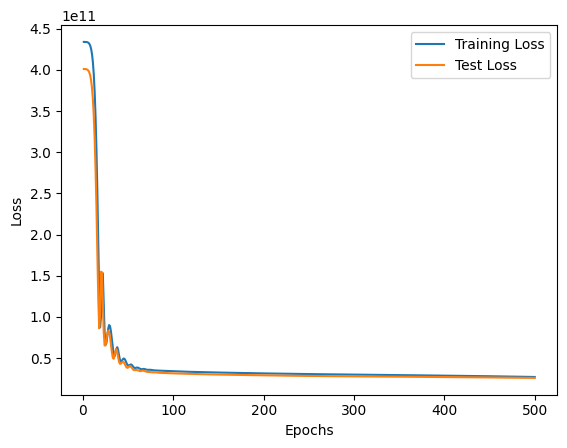

In [323]:
# loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Test MSE: 25844127744.0000
Adjusted R²: 0.7805


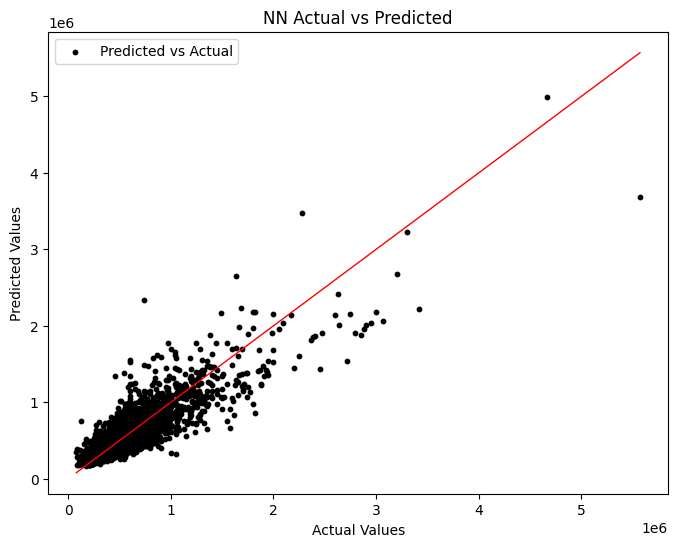

In [332]:
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_mse = mean_squared_error(y_test_tensor.numpy(), test_predictions.numpy())
    print(f"Test MSE: {test_mse:.4f}")

    ss_res = torch.sum((y_test_tensor - test_predictions) ** 2)
    ss_tot = torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Calculate Adjusted R^2
    n = X_test.shape[0]  # Number of samples
    p = X_test.shape[1]  # Number of predictors
    adjusted_r2 = 1 - (1 - r2.item()) * (n - 1) / (n - p - 1)
    print(f"Adjusted R²: {adjusted_r2:.4f}")


    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_tensor.numpy(), test_predictions.numpy(), color='black', s=10, label='Predicted vs Actual')
    plt.plot([y_test_tensor.min(), y_test_tensor.max()], [y_test_tensor.min(), y_test_tensor.max()], 'r', lw=1)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('NN Actual vs Predicted')
    plt.legend()
    plt.show()